In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [376]:
import os
import glob
import tensorflow as tf
import numpy as np
from keras import layers, models, optimizers, losses, metrics, regularizers
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K 

In [377]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

In [378]:
from keras.datasets import mnist

In [452]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape([x_train.shape[0],28,28,1])
x_test = x_test.reshape([x_test.shape[0],28,28,1])

print ("done")

done


In [453]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)



In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx][:,:,0].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [455]:
mean_x = x_train.mean(axis=0)
x_train = x_train - mean_x
max_x = x_train.max(axis=0)
x_train = x_train / 127.5

x_test = x_test - mean_x
x_test = x_test / 127.5


In [456]:
x_train.max()

1.9998324183006535

In [457]:
def build_encoder():
    img_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(filters = 16,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(img_input)
    x = layers.Conv2D(filters = 32,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(x)    
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters = 32,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(x)  
    
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    
    x = layers.Conv2D(filters = 1,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(x)  
    x = layers.Reshape([7*7*1])(x)
    x = layers.Dense(32)(x)
    output = x

    return models.Model(img_input, output, 
                        name='encoder')

In [458]:
K.clear_session()

In [459]:
encoder = build_encoder()

In [460]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 1)           289       
__________

In [461]:
def build_decoder():
    emb_input = layers.Input(shape=(32,))
    x = layers.Dense(units=49,activation='relu')(emb_input)
    x = layers.Dense(units=49,activation='relu')(x)
    x = layers.Reshape((7,7,1))(x)
    x = layers.Conv2D(filters = 32,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(x)    
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(filters = 32,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(x)    
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(filters = 1,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='tanh')(x)    
    output = x
    return models.Model(emb_input, output, 
                        name='decoder')

In [462]:
decoder = build_decoder()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 49)                1617      
_________________________________________________________________
dense_3 (Dense)              (None, 49)                2450      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          320       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        9248      
__________

In [463]:
def build_autoencoder():
    img_input = layers.Input(shape=(28, 28, 1))
    encoder = build_encoder()
    decoder = build_decoder()
    
    embedding = encoder(img_input)
    reconstructed_input = decoder(embedding)
    
    return models.Model(img_input, reconstructed_input, 
                        name='autoencoder')

In [464]:
K.clear_session()
model = build_autoencoder()

In [465]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 32)                15937     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         13924     
Total params: 29,861
Trainable params: 29,861
Non-trainable params: 0
_________________________________________________________________


Тренировочный цикл

In [466]:
model.compile('adam', 'mae')

In [467]:
model.fit(x=x_train, callbacks= [ReduceLROnPlateau(patience=4, monitor='loss', epsilon=1)],
          y=x_train, 
          batch_size=64, 
          epochs=6)

C:\Users\Public\anaconda3\lib\site-packages\keras\callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/6
60000/60000 [==============================] - 319s 5ms/step - loss: 0.1918
Epoch 2/6
60000/60000 [==============================] - 357s 6ms/step - loss: 0.1503
Epoch 3/6
60000/60000 [==============================] - 335s 6ms/step - loss: 0.1387
Epoch 4/6
60000/60000 [==============================] - 297s 5ms/step - loss: 0.1325
Epoch 5/6
60000/60000 [==============================] - 286s 5ms/step - loss: 0.1285
Epoch 6/6
60000/60000 [==============================] - 284s 5ms/step - loss: 0.1236


In [469]:
output = model.predict(x_test, batch_size=128)

output = output * 127.5
output = output + mean_x



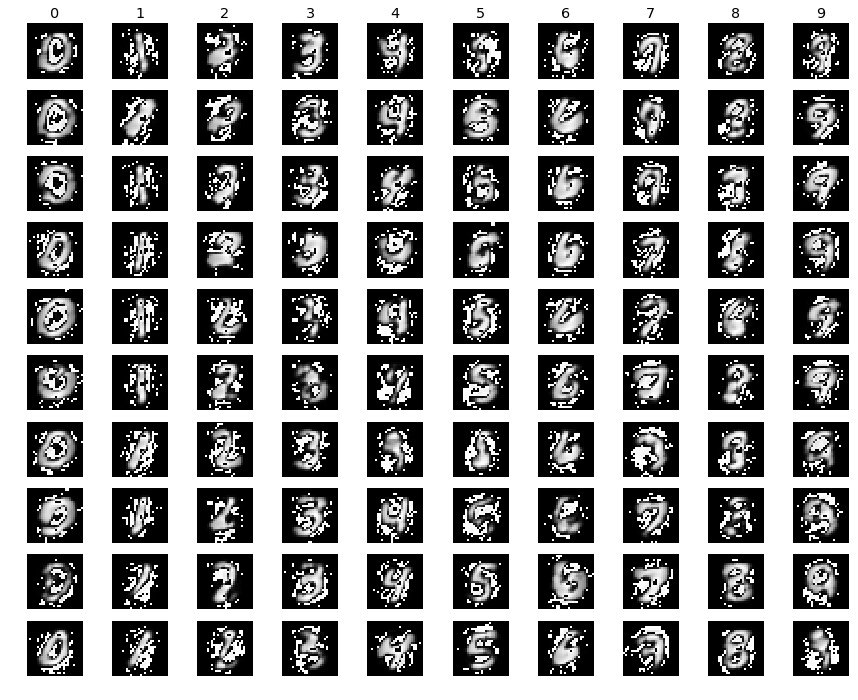

In [470]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(np.squeeze(output[idx]).astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()